# Training

In [1]:
import torch
import random
import numpy as np

# from torchvision import transforms
from PIL import Image
import os
import pandas as pd
import json

from matplotlib import pyplot as plt

from ipynb.fs.full.read_in_data import read_in_data

from transforms import train_transforms, val_transforms
from dataset import ContrastiveLearningDataset, SimpleDataset

## Loading data

In [2]:
with open("../public_dataset/reference_images_part1.json") as f:
    ref_json = json.load(f)

dir_str = "../public_dataset/reference_images_part1"
df = read_in_data(dir_str, ref_json)

df = df.sort_values('category_id')
df = df.reset_index(drop=True)
df.head()

,id,image_id,bbox,category_id,img
0,155,33,"[116, 97, 411, 126]",1,<PIL.Image.Image image mode=RGB size=411x126 a...
1,33,6,"[573, 246, 164, 298]",1,<PIL.Image.Image image mode=RGB size=164x298 a...
2,32,6,"[114, 269, 363, 223]",1,<PIL.Image.Image image mode=RGB size=363x223 a...
3,30,6,"[622, 218, 374, 220]",1,<PIL.Image.Image image mode=RGB size=374x220 a...
4,29,6,"[743, 486, 354, 132]",1,<PIL.Image.Image image mode=RGB size=354x132 a...


In [3]:
from torchvision.transforms import transforms as T

1
torch.Size([3, 224, 224])


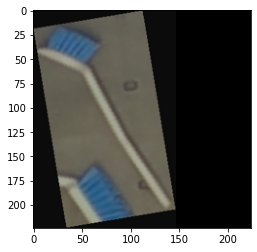

In [4]:
id = 1
img = df['img'][id]
print(df['category_id'][id])

img = train_transforms(img)

print(img.shape)

plt.imshow(img.permute(1, 2, 0))

In [5]:
images = df['img']
labels = df['category_id']

val_labels = [1, 2, 3]
val_ids = ~labels.isin(val_labels) # TODO

val_images = images[val_ids].reset_index(drop=True)
val_labels = labels[val_ids].reset_index(drop=True)

train_ids = ~val_ids

train_images = images[train_ids].reset_index(drop=True)
train_labels = labels[train_ids].reset_index(drop=True)

In [6]:
train_dataset = ContrastiveLearningDataset(train_images, train_labels, train_transforms)
val_dataset = SimpleDataset(train_images, train_labels, val_transforms)

In [7]:
id_ = random.randrange(0, len(train_dataset))

image, label = train_dataset[id_]

# f, axarr = plt.subplots(1,2) 

# axarr[0].imshow(image_1.permute(1, 2, 0))
# axarr[1].imshow(image_2.permute(1, 2, 0))

# sign, weight

print(image.mean(), image.max(), image.min())

tensor(0.2048) tensor(0.9569) tensor(0.)


In [8]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"DEVICE: {DEVICE}")

DEVICE: cuda


In [9]:
BATCH_SIZE = 8

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    pin_memory=False,
)

## Training loop

In [10]:
EPOCHS = 100

In [11]:
from model import ImageEmbeddingModel

torch.Size([1, 384])


In [12]:
out_dim=32

model = ImageEmbeddingModel(out_dim=out_dim, efficientnet_model_name="efficientnet-b0").to(device=DEVICE)
# optimizer = torch.optim.Adam(model.get_last_params())
optimizer = torch.optim.Adam(model.get_last_params())

Loaded pretrained weights for efficientnet-b0


In [13]:
from losses import ContrastiveLoss, CosineSimilarityLoss

# loss_function = CosineSimilarityLoss(pos_weight=3)
loss_function = ContrastiveLoss(np.sqrt(out_dim), pos_weight=3)
# loss_function2 = ContrastiveLoss(np.sqrt(out_dim), reduction="NONE")
# cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

# def contrastive_learning_loss(v_1, v_2, weight, sign):
#     cos_sim = cos(v_1, v_2)
#     loss = - weight * cos_sim * sign
#     return loss.mean()



In [14]:

from sklearn.decomposition import PCA

def validate(model, dataset):
    embeddings = []
    labels = []
    for i in range(len(dataset)):
        image, label = dataset[i]
        image = image.to(device=DEVICE).unsqueeze(0)
        label = label
        emb = model(image)
        embeddings.append(emb[0].detach().cpu().numpy())
        labels.append(label)

    emb4lab_dict = {}
    for e, l in zip(embeddings, labels):
        if l not in emb4lab_dict.keys():
            emb4lab_dict[l] = [e]
        else:
            emb4lab_dict[l].append(e)
    for l in emb4lab_dict.keys():
        emb4lab_dict[l] = np.mean(np.array(emb4lab_dict[l]), axis=0)
    
    lbl_dsts = {}
    for e, l in zip(embeddings, labels):
        dst = np.sum(np.abs(e - emb4lab_dict[l]))
        if l not in lbl_dsts.keys():
            lbl_dsts[l] = [dst]
        else:
            lbl_dsts[l].append(dst)
    for l in lbl_dsts.keys():
        lbl_dsts[l] = np.mean(np.array(lbl_dsts[l]), axis=0)
        print(f"LABEL: {l} - MEAN DST: {lbl_dsts[l]}")
    
    embeddings = np.array(embeddings)
    labels = np.array(labels)
    
    pca = PCA()
    pca.fit(embeddings)
    emb2d = pca.transform(embeddings)
    plt.scatter(emb2d[:,0], emb2d[:,1], c=labels)
    plt.show()

LABEL: 1 - MEAN DST: 11.914267539978027
LABEL: 2 - MEAN DST: 11.443568229675293
LABEL: 3 - MEAN DST: 12.037978172302246


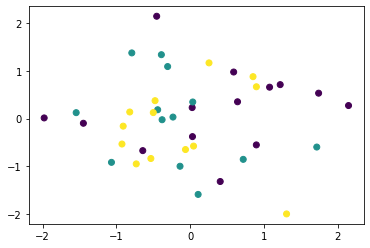

Epoch: 1/100: Loss: 37.17973518371582
LABEL: 1 - MEAN DST: 27.082735061645508
LABEL: 2 - MEAN DST: 31.053794860839844
LABEL: 3 - MEAN DST: 24.708690643310547


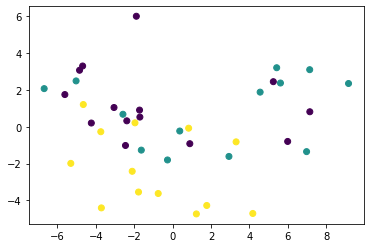

Epoch: 2/100: Loss: 36.50727462768555
Epoch: 3/100: Loss: 50.35201644897461
Epoch: 4/100: Loss: 35.734779357910156
Epoch: 5/100: Loss: 33.40143394470215
Epoch: 6/100: Loss: 20.61604404449463
LABEL: 1 - MEAN DST: 22.937896728515625
LABEL: 2 - MEAN DST: 26.008256912231445
LABEL: 3 - MEAN DST: 26.95265007019043


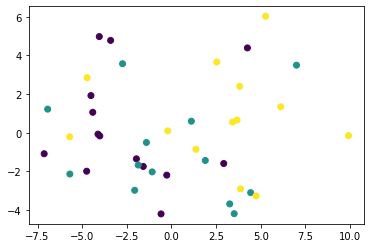

Epoch: 7/100: Loss: 20.443363189697266
Epoch: 8/100: Loss: 14.626389026641846
Epoch: 9/100: Loss: 20.227824687957764
Epoch: 10/100: Loss: 11.583117008209229
Epoch: 11/100: Loss: 9.710229396820068
LABEL: 1 - MEAN DST: 16.406312942504883
LABEL: 2 - MEAN DST: 14.769594192504883
LABEL: 3 - MEAN DST: 14.58033561706543


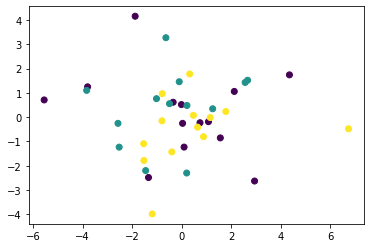

Epoch: 12/100: Loss: 8.250612258911133
Epoch: 13/100: Loss: 8.692621231079102
Epoch: 14/100: Loss: 7.786832332611084
Epoch: 15/100: Loss: 8.172203063964844
Epoch: 16/100: Loss: 7.261857271194458
LABEL: 1 - MEAN DST: 11.391812324523926
LABEL: 2 - MEAN DST: 12.562006950378418
LABEL: 3 - MEAN DST: 13.508930206298828


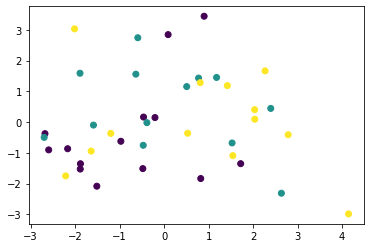

Epoch: 17/100: Loss: 7.132389068603516
Epoch: 18/100: Loss: 5.931988716125488
Epoch: 19/100: Loss: 5.781517267227173
Epoch: 20/100: Loss: 6.18044638633728
Epoch: 21/100: Loss: 4.6068525314331055
LABEL: 1 - MEAN DST: 10.273493766784668
LABEL: 2 - MEAN DST: 9.757634162902832
LABEL: 3 - MEAN DST: 10.64377212524414


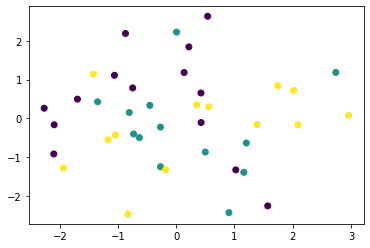

Epoch: 22/100: Loss: 3.2200541496276855
Epoch: 23/100: Loss: 4.123783111572266
Epoch: 24/100: Loss: 3.086807370185852
Epoch: 25/100: Loss: 3.211695671081543
Epoch: 26/100: Loss: 3.729067087173462
LABEL: 1 - MEAN DST: 8.414605140686035
LABEL: 2 - MEAN DST: 8.756743431091309
LABEL: 3 - MEAN DST: 8.231677055358887


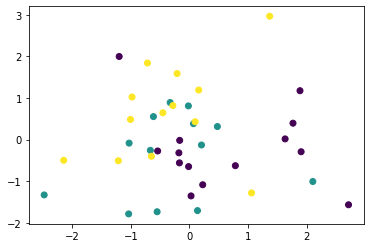

Epoch: 27/100: Loss: 2.853639006614685
Epoch: 28/100: Loss: 2.7930716276168823
Epoch: 29/100: Loss: 3.2110817432403564
Epoch: 30/100: Loss: 3.215384602546692
Epoch: 31/100: Loss: 2.3770708441734314
LABEL: 1 - MEAN DST: 7.618517875671387
LABEL: 2 - MEAN DST: 7.937462329864502
LABEL: 3 - MEAN DST: 8.234147071838379


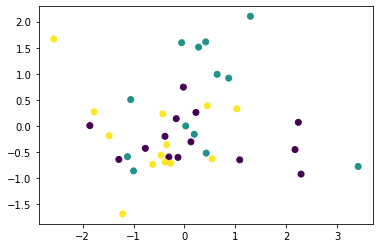

Epoch: 32/100: Loss: 2.696633815765381
Epoch: 33/100: Loss: 2.3311938047409058
Epoch: 34/100: Loss: 1.8579544425010681
Epoch: 35/100: Loss: 2.4753023386001587
Epoch: 36/100: Loss: 1.6946557760238647
LABEL: 1 - MEAN DST: 8.745158195495605
LABEL: 2 - MEAN DST: 7.550098896026611
LABEL: 3 - MEAN DST: 8.338370323181152


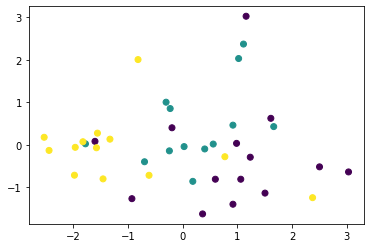

Epoch: 37/100: Loss: 2.1333802342414856
Epoch: 38/100: Loss: 1.9855217933654785
Epoch: 39/100: Loss: 1.4475482106208801
Epoch: 40/100: Loss: 1.913921594619751
Epoch: 41/100: Loss: 1.4876545071601868
LABEL: 1 - MEAN DST: 7.639895915985107
LABEL: 2 - MEAN DST: 6.696188926696777
LABEL: 3 - MEAN DST: 7.192310810089111


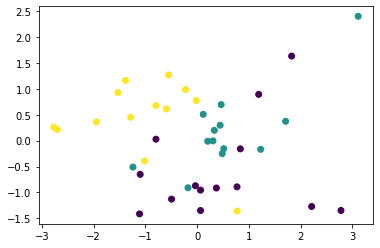

Epoch: 42/100: Loss: 2.0694401264190674
Epoch: 43/100: Loss: 2.017330288887024
Epoch: 44/100: Loss: 1.5445374846458435
Epoch: 45/100: Loss: 1.3303515315055847
Epoch: 46/100: Loss: 1.5445558428764343
LABEL: 1 - MEAN DST: 6.627655029296875
LABEL: 2 - MEAN DST: 6.223353385925293
LABEL: 3 - MEAN DST: 8.739076614379883


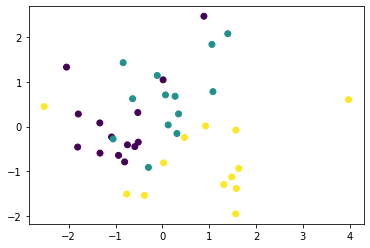

Epoch: 47/100: Loss: 1.0026021003723145
Epoch: 48/100: Loss: 1.3068573474884033
Epoch: 49/100: Loss: 1.0527742803096771
Epoch: 50/100: Loss: 1.491104781627655
Epoch: 51/100: Loss: 1.173041820526123
LABEL: 1 - MEAN DST: 7.401952266693115
LABEL: 2 - MEAN DST: 6.658806800842285
LABEL: 3 - MEAN DST: 7.215590476989746


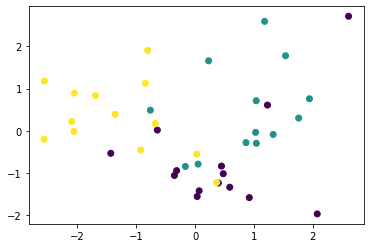

Epoch: 52/100: Loss: 1.527185082435608
Epoch: 53/100: Loss: 1.2227460741996765
Epoch: 54/100: Loss: 1.2432957589626312
Epoch: 55/100: Loss: 0.9645967483520508
Epoch: 56/100: Loss: 0.9266709387302399
LABEL: 1 - MEAN DST: 7.022976398468018
LABEL: 2 - MEAN DST: 7.307953834533691
LABEL: 3 - MEAN DST: 7.04272985458374


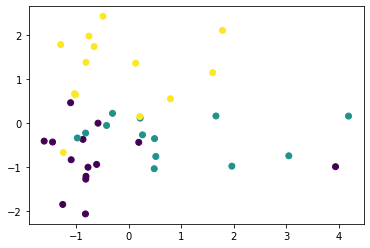

Epoch: 57/100: Loss: 0.9602153599262238
Epoch: 58/100: Loss: 1.103790283203125
Epoch: 59/100: Loss: 1.0645171403884888
Epoch: 60/100: Loss: 0.6937205791473389
Epoch: 61/100: Loss: 0.5560395568609238
LABEL: 1 - MEAN DST: 7.864945411682129
LABEL: 2 - MEAN DST: 7.5435919761657715
LABEL: 3 - MEAN DST: 8.911008834838867


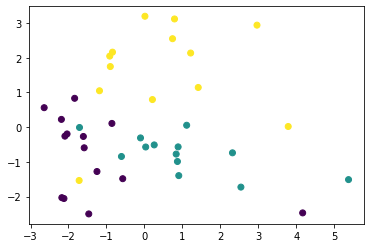

Epoch: 62/100: Loss: 0.6576479375362396
Epoch: 63/100: Loss: 0.8135584592819214
Epoch: 64/100: Loss: 0.6542809009552002
Epoch: 65/100: Loss: 1.0310181379318237
Epoch: 66/100: Loss: 1.2889281213283539
LABEL: 1 - MEAN DST: 6.6761040687561035
LABEL: 2 - MEAN DST: 8.69497013092041
LABEL: 3 - MEAN DST: 7.828804016113281


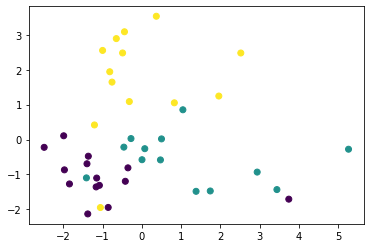

Epoch: 67/100: Loss: 1.05235156416893
Epoch: 68/100: Loss: 1.1782742142677307
Epoch: 69/100: Loss: 0.735449343919754
Epoch: 70/100: Loss: 0.5787460207939148
Epoch: 71/100: Loss: 0.646852970123291
LABEL: 1 - MEAN DST: 6.505366802215576
LABEL: 2 - MEAN DST: 7.012937545776367
LABEL: 3 - MEAN DST: 6.570091247558594


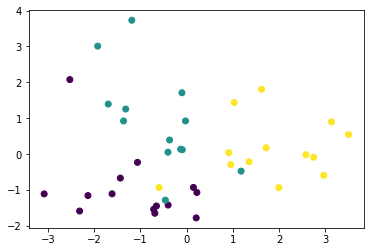

Epoch: 72/100: Loss: 0.4225974977016449
Epoch: 73/100: Loss: 0.6472224593162537
Epoch: 74/100: Loss: 0.5465699136257172
Epoch: 75/100: Loss: 0.4193936437368393
Epoch: 76/100: Loss: 1.0349629521369934
LABEL: 1 - MEAN DST: 6.025290489196777
LABEL: 2 - MEAN DST: 6.8167338371276855
LABEL: 3 - MEAN DST: 6.569224834442139


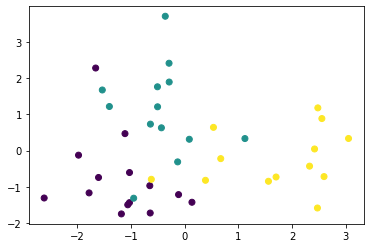

Epoch: 77/100: Loss: 1.0122821033000946
Epoch: 78/100: Loss: 0.6168482452630997
Epoch: 79/100: Loss: 0.6271338760852814
Epoch: 80/100: Loss: 0.4259234070777893
Epoch: 81/100: Loss: 0.494976282119751
LABEL: 1 - MEAN DST: 6.557209014892578
LABEL: 2 - MEAN DST: 6.613895893096924
LABEL: 3 - MEAN DST: 6.865079879760742


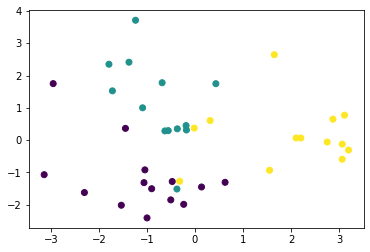

Epoch: 82/100: Loss: 0.6351709961891174
Epoch: 83/100: Loss: 0.4506431818008423
Epoch: 84/100: Loss: 0.5899846851825714
Epoch: 85/100: Loss: 0.6160538345575333
Epoch: 86/100: Loss: 0.359047532081604
LABEL: 1 - MEAN DST: 6.187270164489746
LABEL: 2 - MEAN DST: 9.364027976989746
LABEL: 3 - MEAN DST: 7.006577014923096


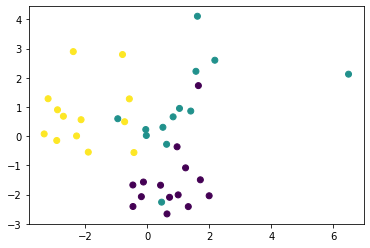

Epoch: 87/100: Loss: 0.40861012041568756
Epoch: 88/100: Loss: 0.27050384134054184
Epoch: 89/100: Loss: 0.2810920998454094
Epoch: 90/100: Loss: 0.3409106954932213
Epoch: 91/100: Loss: 0.41247984766960144
LABEL: 1 - MEAN DST: 5.871972560882568
LABEL: 2 - MEAN DST: 8.29533576965332
LABEL: 3 - MEAN DST: 6.868484020233154


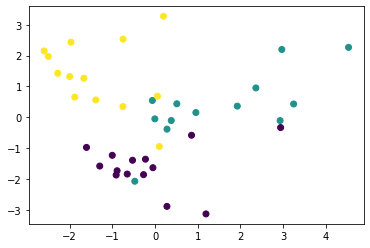

Epoch: 92/100: Loss: 0.6310122162103653
Epoch: 93/100: Loss: 0.507259801030159
Epoch: 94/100: Loss: 0.3531666696071625
Epoch: 95/100: Loss: 0.9839121997356415
Epoch: 96/100: Loss: 0.7022809386253357
LABEL: 1 - MEAN DST: 6.365602016448975
LABEL: 2 - MEAN DST: 6.725009441375732
LABEL: 3 - MEAN DST: 5.939760684967041


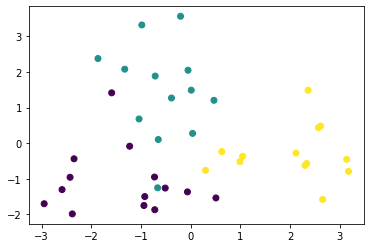

Epoch: 97/100: Loss: 0.37069813907146454
Epoch: 98/100: Loss: 1.040140375494957
Epoch: 99/100: Loss: 0.6171748042106628
Epoch: 100/100: Loss: 0.5881365835666656


In [15]:
torch.cuda.empty_cache()
LOSS_COUNT_SAMPLES = 24

validate(model, val_dataset)
optimizer.zero_grad()
for epoch in range(EPOCHS):
    if epoch == 0:
        optimizer = torch.optim.Adam(model.parameters())
    losses = []
    all_labels = []
    all_ys = []
    for i, data in enumerate(train_loader, 0):
        torch.cuda.empty_cache()
        images, labels = data
        images = images.to(device=DEVICE)
        
        ys = model(images)
        
        all_ys.append(ys)
        all_labels.append(labels)
        
        if (i+1) % (LOSS_COUNT_SAMPLES // BATCH_SIZE) == 0:
            loss = loss_function(torch.cat(all_ys), torch.cat(all_labels))
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().item())
            all_ys = []
            all_labels = []
            optimizer.zero_grad()
        
    total_loss = np.mean(losses)
    print(f"Epoch: {epoch + 1}/{EPOCHS}: Loss: {total_loss}")
    if epoch % 5 == 0:
        validate(model, val_dataset)
    
        # YOUR CODE HERE
        
        # TODO: walidacja, wypisywanie lossów itd
        # END YOUR CODE

In [16]:
torch.save(model.state_dict(), './efficientnet_based.params')